<a href="https://colab.research.google.com/github/lllllh1115/DASC7606/blob/Assignment1/Lian_Huan_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework for COMP7606 Assignment 1

In this tutorial, I will show you how to
- train a baseline model for cat pose estimation

This tutorial only contains some basic usage of MMPose. 
Please learn more about MMPose at https://mmpose.readthedocs.io/en/latest/.

Let's start!

## Install MMPose

We recommend to use a conda environment to install mmpose and its dependencies. And compilers `nvcc` and `gcc` are required.

In [ ]:
# check NVCC version
!nvcc -V

# check GCC version
!gcc --version

# check python in conda environment
!which python

# Different container might contain different CUDA version!
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

/usr/local/bin/python
Sat Mar 12 07:37:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|====================

In [ ]:
# install pytorch
!pip install torch

# install mmcv-full. Please follow the instruction (https://github.com/open-mmlab/mmcv) to install mmcv-full.
!pip install mmcv-full==1.3.18 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

# install mmdet for inference demo
!pip install mmdet

# clone mmpose repo
!rm -rf mmpose
!git clone https://github.com/open-mmlab/mmpose.git

# clone necessary files for this assignment
!rm -rf COMP7606
!git clone https://github.com/jin-s13/COMP7606.git

%cd mmpose

# install mmpose dependencies
!pip install -r requirements.txt

# install mmpose in develop mode
!pip install -e .

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 58.0 MB 10.2 MB/s 
     |████████████████████████████████| 190 kB 5.2 MB/s 
     |████████████████████████████████| 1.3 MB 5.3 MB/s 
Cloning into 'mmpose'...
remote: Enumerating objects: 17888, done.
remote: Counting objects: 100% (2812/2812), done.
remote: Compressing objects: 100% (1137/1137), done.
remote: Total 17888 (delta 1814), reused 2393 (delta 1643), pack-reused 15076
Receiving objects: 100% (17888/17888), 26.14 MiB | 31.34 MiB/s, done.
Resolving deltas: 100% (12385/12385), done.
Cloning into 'COMP7606'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Unpacking objects: 100% (36/36), done.
/content/mmpose
Ignoring dataclasses: markers 'python_version == "3.6"' don't match your environment
  Cloning https://github.com/svenkreiss/poseval.git to /tmp/pip-install-elccklpo/poseval_3ff44415f6774e97ad3

In [ ]:
# Check Pytorch installation
import torch, torchvision
print('torch version:', torch.__version__, torch.cuda.is_available())
print('torchvision version:', torchvision.__version__)

# Check MMPose installation
import mmpose
print('mmpose version:', mmpose.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print('cuda version:', get_compiling_cuda_version())
print('compiler information:', get_compiler_version())
!pwd

torch version: 1.10.0+cu111 True
torchvision version: 0.11.1+cu111
mmpose version: 0.24.0
cuda version: 11.1
compiler information: GCC 7.3
/content/mmpose


In [ ]:
!pip install tensorboard tensorboardX

     |████████████████████████████████| 125 kB 4.9 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.2.0
    Uninstalling importlib-metadata-4.2.0:
      Successfully uninstalled importlib-metadata-4.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flake8 4.0.1 requires importlib-metadata<4.3; python_version < "3.8", but you have importlib-metadata 4.11.2 which is incompatible.


## Train a cat pose estimation model 

To train a cat pose estimation model on a customized dataset with MMPose, there are usually three steps:
1. Support the dataset in MMPose
1. Create a config
1. Perform training and evaluation

### Add a new dataset

There are two methods to support a customized dataset in MMPose. The first one is to convert the data to a supported format (e.g. COCO) and use the corresponding dataset class (e.g. TopdownCOCODataset), as described in the [document](https://mmpose.readthedocs.io/en/latest/tutorials/2_new_dataset.html#reorganize-dataset-to-existing-format). The second one is to add a new dataset class. In this tutorial, we give an example of the second method.

We first download the dataset, which contains 1328 images (1000 for training, 128 for validation and 200 for testing).

In [ ]:
!ls -a

.	      docs	       model-index.yml		requirements.txt
..	      .git	       .pre-commit-config.yaml	resources
.circleci     .github	       .pylintrc		setup.cfg
CITATION.cff  .gitignore       pytest.ini		setup.py
configs       LICENSE	       README_CN.md		tests
demo	      MANIFEST.in      README.md		tools
.dev_scripts  mmpose	       .readthedocs.yml
docker	      mmpose.egg-info  requirements


In [ ]:
# download dataset
%mkdir data
%mkdir data/cats
%cp ../COMP7606/Cats.tar data/cats
%cd data/cats
!tar -xf Cats.tar
!ls -a
%cd ../../

/content/mmpose/data/cats
.  ..  annotations  Cats.tar  images
/content/mmpose


In [ ]:
# The <_base_/cats.py> contains the dataset information, i.e. the keypoint definition, flip pairs, and sigmas for evaluation.
!cp ../COMP7606/configs/_base_/cats.py configs/_base_/datasets/ 
# The <configs/cats/res50_cats_128x128.py> is a baseline config file. You can use this to train/evaluate the model. 
# But the performance of the baseline model is not good enough. You should try to improve it!
!cp -r ../COMP7606/configs/cats configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/ 

After downloading the data, we implement a new dataset class to load data samples for model training and validation. In this assignment, we are going to train a top-down pose estimation model (refer to [Top-down Pose Estimation](https://github.com/open-mmlab/mmpose/tree/master/configs/body/2d_kpt_sview_rgb_img/topdown_heatmap#readme) for a brief introduction), the new dataset class inherits `AnimalAP10KDataset`.

In [ ]:
import json
import os
import os.path as osp
from collections import OrderedDict

import numpy as np

from mmpose.core.evaluation.top_down_eval import (keypoint_nme,keypoint_pck_accuracy)
from mmpose.datasets.builder import DATASETS
from mmpose.datasets.datasets.animal import AnimalAP10KDataset


@DATASETS.register_module()
class AnimalCatsDataset(AnimalAP10KDataset):

	def __init__(self,
				 ann_file,
				 img_prefix,
				 data_cfg,
				 pipeline,
				 dataset_info=None,
				 test_mode=False):
		super().__init__(
			ann_file, img_prefix, data_cfg, pipeline, dataset_info, test_mode=test_mode)

### Create a training config file

### Restart from HERE!

In the next step, we create a config file which configures the model, dataset and runtime settings. More information can be found at [Learn about Configs](https://mmpose.readthedocs.io/en/latest/tutorials/0_config.html). A common practice to create a config file is deriving from a existing one. In this tutorial, we load a config file that trains a ResNet on COCO dataset, and modify it to adapt to the Cats dataset.

Note that the following config file is just an example to show how to train a model. 
This config file is far from optimal and the baseline model is not good enough. You should try your best to improve it. 

Using this https://download.openmmlab.com/mmpose/animal/hrnet/hrnet_w48_ap10k_256x256-d95ab412_20211029.pth

In [ ]:
from mmcv import Config
cfg = Config.fromfile(
    './configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/res50_cats_128x128.py'
)

# set basic configs
cfg.data_root = 'data/cats'
cfg.work_dir = 'work_dirs/res50_cats_128x128'
cfg.gpu_ids = range(1)
cfg.seed = 0

# set log interval
cfg.log_config.interval = 1

# set evaluation configs
cfg.evaluation.interval = 5

# set batch size
cfg.data.samples_per_gpu = 16
cfg.data.val_dataloader = dict(samples_per_gpu=16)
cfg.data.test_dataloader = dict(samples_per_gpu=16)


# set dataset configs
cfg.data.train.type = 'AnimalCatsDataset'
cfg.data.train.ann_file = f'{cfg.data_root}/annotations/train.json'
cfg.data.train.img_prefix = f'{cfg.data_root}/images/'

cfg.data.val.type = 'AnimalCatsDataset'
cfg.data.val.ann_file = f'{cfg.data_root}/annotations/val.json'
cfg.data.val.img_prefix = f'{cfg.data_root}/images/'

cfg.data.test.type = 'AnimalCatsDataset'
cfg.data.test.ann_file = f'{cfg.data_root}/annotations/test_info.json'
cfg.data.test.img_prefix = f'{cfg.data_root}/images/'

print(cfg.pretty_text)


dataset_info = dict(
    dataset_name='cats',
    paper_info=dict(
        title='Assignment for COMP7606',
        year='2022',
        homepage='https://github.com/jin-s13/COMP7606'),
    keypoint_info=dict({
        0:
        dict(
            name='L_Eye', id=0, color=[0, 255, 0], type='upper', swap='R_Eye'),
        1:
        dict(
            name='R_Eye',
            id=1,
            color=[255, 128, 0],
            type='upper',
            swap='L_Eye'),
        2:
        dict(name='Nose', id=2, color=[51, 153, 255], type='upper', swap=''),
        3:
        dict(name='Neck', id=3, color=[51, 153, 255], type='upper', swap=''),
        4:
        dict(
            name='Root of tail',
            id=4,
            color=[51, 153, 255],
            type='lower',
            swap=''),
        5:
        dict(
            name='L_Shoulder',
            id=5,
            color=[51, 153, 255],
            type='upper',
            swap='R_Shoulder'),
        6:
        dict(
  

### Train and Evaluation

In [ ]:
from mmpose.datasets import build_dataset
from mmpose.models import build_posenet
from mmpose.apis import train_model
import mmcv

# build dataset
datasets = [build_dataset(cfg.data.train)]

# build model
model = build_posenet(cfg.model)

# create work_dir
mmcv.mkdir_or_exist(cfg.work_dir)

# train model
train_model(
    model, datasets, cfg, distributed=False, validate=True, meta=dict())

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
=> num_images: 1000
=> load 1104 samples
load checkpoint from http path: https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w48-8ef0771d.pth


Downloading: "https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w48-8ef0771d.pth" to /root/.cache/torch/hub/checkpoints/hrnet_w48-8ef0771d.pth


  0%|          | 0.00/264M [00:00<?, ?B/s]

2022-03-12 06:26:27,128 - mmpose - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.0.0.0.conv1.weight, head.0.0.0.bn1.weight, head.0.0.0.bn1.bias, head.0.0.0.bn1.running_mean, head.0.0.0.bn1.running_var, head.0.0.0.conv2.weight, head.0.0.0.bn2.weight, head.0.0.0.bn2.bias, head.0.0.0.bn2.running_mean, head.0.0.0.bn2.running_var, head.0.0.0.conv3.weight, head.0.0.0.bn3.weight, head.0.0.0.bn3.bias, head.0.0.0.bn3.running_mean, head.0.0.0.bn3.running_var, head.0.0.0.downsample.0.weight, head.0.0.0.downsample.1.weight, head.0.0.0.downsample.1.bias, head.0.0.0.downsample.1.running_mean, head.0.0.0.downsample.1.running_var, head.0.1.0.conv1.weight, head.0.1.0.bn1.weight, head.0.1.0.bn1.bias, head.0.1.0.bn1.running_mean, head.0.1.0.bn1.running_var, head.0.1.0.conv2.weight, head.0.1.0.bn2.weight, head.0.1.0.bn2.bias, head.0.1.0.bn2.running_mean, head.0.1.0.bn2.running_var, head.0.1.0.conv3.weight, head.0.1.0.bn3.weight, head.0.1.0.bn3.bi

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 124
=> load 132 samples


2022-03-12 06:26:45,582 - mmpose - INFO - Epoch [1][1/69]	lr: 4.000e-07, eta: 4:16:40, time: 7.444, data_time: 5.276, memory: 4432, heatmap_loss: 0.0004, acc_pose: 0.0401, loss: 0.0004
2022-03-12 06:26:47,450 - mmpose - INFO - Epoch [1][2/69]	lr: 4.036e-05, eta: 2:40:28, time: 1.868, data_time: 0.015, memory: 5176, heatmap_loss: 0.0004, acc_pose: 0.0110, loss: 0.0004
2022-03-12 06:26:49,263 - mmpose - INFO - Epoch [1][3/69]	lr: 8.032e-05, eta: 2:07:44, time: 1.813, data_time: 0.008, memory: 5179, heatmap_loss: 0.0004, acc_pose: 0.0118, loss: 0.0004
2022-03-12 06:26:51,101 - mmpose - INFO - Epoch [1][4/69]	lr: 1.203e-04, eta: 1:51:35, time: 1.838, data_time: 0.014, memory: 5179, heatmap_loss: 0.0003, acc_pose: 0.0368, loss: 0.0003
2022-03-12 06:26:52,923 - mmpose - INFO - Epoch [1][5/69]	lr: 1.602e-04, eta: 1:41:46, time: 1.822, data_time: 0.010, memory: 5179, heatmap_loss: 0.0004, acc_pose: 0.0632, loss: 0.0004
2022-03-12 06:26:54,751 - mmpose - INFO - Epoch [1][6/69]	lr: 2.002e-04, et

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 13.2 task/s, elapsed: 10s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.445
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.788
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.455
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.439
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.537
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.841
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2022-03-12 06:38:21,420 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_5.pth.
2022-03-12 06:38:21,422 - mmpose - INFO - Best AP is 0.4445 at 5 epoch.
2022-03-12 06:38:21,435 - mmpose - INFO - Epoch(val) [5][9]	AP: 0.4445, AP .5: 0.7881, AP .75: 0.4554, AP (M): 0.1409, AP (L): 0.4390, AR: 0.5371, AR .5: 0.8409, AR .75: 0.5682, AR (M): 0.6400, AR (L): 0.5317
2022-03-12 06:38:26,173 - mmpose - INFO - Epoch [6][1/69]	lr: 4.000e-04, eta: 0:54:44, time: 4.710, data_time: 2.633, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.6446, loss: 0.0002
2022-03-12 06:38:28,015 - mmpose - INFO - Epoch [6][2/69]	lr: 4.000e-04, eta: 0:54:42, time: 1.842, data_time: 0.016, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.6068, loss: 0.0002
2022-03-12 06:38:29,853 - mmpose - INFO - Epoch [6][3/69]	lr: 4.000e-04, eta: 0:54:39, time: 1.838, data_time: 0.008, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.5828, loss: 0.0002
2022-03-12 06:38:31,688 - mmpose - INFO - Epoch [6][4/69]	lr: 4.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 12.9 task/s, elapsed: 10s, ETA:     0s

2022-03-12 06:50:00,132 - mmpose - INFO - The previous best checkpoint /content/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_5.pth was removed


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.485
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.860
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.450
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.580
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.886
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

2022-03-12 06:50:05,743 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_10.pth.
2022-03-12 06:50:05,746 - mmpose - INFO - Best AP is 0.4852 at 10 epoch.
2022-03-12 06:50:05,751 - mmpose - INFO - Epoch(val) [10][9]	AP: 0.4852, AP .5: 0.8605, AP .75: 0.4498, AP (M): 0.2238, AP (L): 0.4817, AR: 0.5795, AR .5: 0.8864, AR .75: 0.5682, AR (M): 0.5600, AR (L): 0.5794
2022-03-12 06:50:10,568 - mmpose - INFO - Epoch [11][1/69]	lr: 4.000e-05, eta: 0:43:43, time: 4.764, data_time: 2.696, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.6999, loss: 0.0002
2022-03-12 06:50:12,491 - mmpose - INFO - Epoch [11][2/69]	lr: 4.000e-05, eta: 0:43:41, time: 1.923, data_time: 0.017, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.5937, loss: 0.0002
2022-03-12 06:50:14,373 - mmpose - INFO - Epoch [11][3/69]	lr: 4.000e-05, eta: 0:43:39, time: 1.882, data_time: 0.016, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.6963, loss: 0.0002
2022-03-12 06:50:16,262 - mmpose - INFO - Epoch [11][4/69]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 13.2 task/s, elapsed: 10s, ETA:     0s

2022-03-12 07:01:52,475 - mmpose - INFO - The previous best checkpoint /content/mmpose/work_dirs/res50_cats_128x128/best_AP_epoch_10.pth was removed


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.539
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.896
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.529
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.536
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.635
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.924
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.659
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

2022-03-12 07:01:59,019 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_15.pth.
2022-03-12 07:01:59,021 - mmpose - INFO - Best AP is 0.5388 at 15 epoch.
2022-03-12 07:01:59,028 - mmpose - INFO - Epoch(val) [15][9]	AP: 0.5388, AP .5: 0.8956, AP .75: 0.5289, AP (M): 0.2344, AP (L): 0.5359, AR: 0.6348, AR .5: 0.9242, AR .75: 0.6591, AR (M): 0.7000, AR (L): 0.6341
2022-03-12 07:02:03,909 - mmpose - INFO - Epoch [16][1/69]	lr: 4.000e-06, eta: 0:32:54, time: 4.837, data_time: 2.755, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.7976, loss: 0.0002
2022-03-12 07:02:05,771 - mmpose - INFO - Epoch [16][2/69]	lr: 4.000e-06, eta: 0:32:52, time: 1.864, data_time: 0.016, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.7736, loss: 0.0002
2022-03-12 07:02:07,607 - mmpose - INFO - Epoch [16][3/69]	lr: 4.000e-06, eta: 0:32:50, time: 1.834, data_time: 0.005, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.7753, loss: 0.0002
2022-03-12 07:02:09,460 - mmpose - INFO - Epoch [16][4/69]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 13.3 task/s, elapsed: 10s, ETA:     0s

2022-03-12 07:13:36,087 - mmpose - INFO - Epoch(val) [20][9]	AP: 0.5357, AP .5: 0.8926, AP .75: 0.5105, AP (M): 0.2270, AP (L): 0.5314, AR: 0.6386, AR .5: 0.9242, AR .75: 0.6591, AR (M): 0.7000, AR (L): 0.6381


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.536
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.893
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.510
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.639
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.924
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.659
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

2022-03-12 07:13:40,869 - mmpose - INFO - Epoch [21][1/69]	lr: 4.000e-06, eta: 0:21:52, time: 4.764, data_time: 2.751, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.8278, loss: 0.0002
2022-03-12 07:13:42,721 - mmpose - INFO - Epoch [21][2/69]	lr: 4.000e-06, eta: 0:21:50, time: 1.852, data_time: 0.010, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.8247, loss: 0.0002
2022-03-12 07:13:44,588 - mmpose - INFO - Epoch [21][3/69]	lr: 4.000e-06, eta: 0:21:48, time: 1.866, data_time: 0.015, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.7589, loss: 0.0002
2022-03-12 07:13:46,431 - mmpose - INFO - Epoch [21][4/69]	lr: 4.000e-06, eta: 0:21:47, time: 1.844, data_time: 0.008, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.7323, loss: 0.0002
2022-03-12 07:13:48,278 - mmpose - INFO - Epoch [21][5/69]	lr: 4.000e-06, eta: 0:21:45, time: 1.846, data_time: 0.011, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.8477, loss: 0.0002
2022-03-12 07:13:50,121 - mmpose - INFO - Epoch [21][6/69]	lr: 4.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 13.3 task/s, elapsed: 10s, ETA:     0s

2022-03-12 07:25:13,134 - mmpose - INFO - Epoch(val) [25][9]	AP: 0.5347, AP .5: 0.9102, AP .75: 0.4989, AP (M): 0.2087, AP (L): 0.5295, AR: 0.6348, AR .5: 0.9318, AR .75: 0.6515, AR (M): 0.7200, AR (L): 0.6325


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.535
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.910
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.499
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.209
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.635
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.932
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

2022-03-12 07:25:17,916 - mmpose - INFO - Epoch [26][1/69]	lr: 4.000e-06, eta: 0:10:54, time: 4.763, data_time: 2.663, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.7499, loss: 0.0002
2022-03-12 07:25:19,792 - mmpose - INFO - Epoch [26][2/69]	lr: 4.000e-06, eta: 0:10:53, time: 1.876, data_time: 0.018, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.7028, loss: 0.0002
2022-03-12 07:25:21,657 - mmpose - INFO - Epoch [26][3/69]	lr: 4.000e-06, eta: 0:10:51, time: 1.865, data_time: 0.014, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.7200, loss: 0.0002
2022-03-12 07:25:23,534 - mmpose - INFO - Epoch [26][4/69]	lr: 4.000e-06, eta: 0:10:49, time: 1.877, data_time: 0.010, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.7456, loss: 0.0002
2022-03-12 07:25:25,395 - mmpose - INFO - Epoch [26][5/69]	lr: 4.000e-06, eta: 0:10:47, time: 1.861, data_time: 0.008, memory: 5179, heatmap_loss: 0.0002, acc_pose: 0.7624, loss: 0.0002
2022-03-12 07:25:27,258 - mmpose - INFO - Epoch [26][6/69]	lr: 4.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 13.1 task/s, elapsed: 10s, ETA:     0s

2022-03-12 07:36:58,095 - mmpose - INFO - Epoch(val) [30][9]	AP: 0.5351, AP .5: 0.9147, AP .75: 0.4963, AP (M): 0.2263, AP (L): 0.5285, AR: 0.6341, AR .5: 0.9318, AR .75: 0.6439, AR (M): 0.7000, AR (L): 0.6325


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.535
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.915
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.496
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.634
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.932
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.644
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

As shown above, the performance of the validation set is reported every 5 epochs. We observe that after 20 epochs, the model achieves 0.153 mAP (AP@0.5:0.95). 
Please train the model on the training set and evaluate the model performance locally on the validation set. 

The logs/models can be found in work_dir: "$MMPOSE/work_dirs/res50_cats_128x128"

Parameter tuning: 30 epoachs, 256*256, lr = 3e-4, HRnet.  
1h8min50sec On Tesla 80.  
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.530  
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.865  
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.550  
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.188  
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.526  
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.636  
Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.909  
Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.689  
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.760  
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.633  

Parameter tuning: 30 epoachs, 256*256, lr = 4e-4, HRnet.  
1h8min35sec On Tesla 80.  
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.535  
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.915  
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.496  
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.226  
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.529  
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.634  
Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.932  
Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.644
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.700  
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.633  

Parameter tuning: 30 epoachs, 256*256, lr = 5e-4, HRnet.  
55min On Tesla 80  
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.544  
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.906  
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.523  
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.191  
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.544  
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.623  
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.924  
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.644  
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.620  
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.624  

Parameter tuning: 30 epoachs, 256*256, lr = 8e-4, HRnet.  
1h9min8seconds On Tesla 80  
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.483  
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.836  
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.479  
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.134  
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.480  
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.591  
Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.879  
Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.629  
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.660  
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.588  

Parameter tuning: 30 epoachs, 256\*256, lr = 1e-3, HRnet.  
1h9min12sec On Tesla 80   
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.491  
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.851  
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.502  
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.172  
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.487  
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.595  
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.886  
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.644  
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.680  
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.592  

### Visualize
Here we show how to inference and visualize a model checkpoint. 

load checkpoint from local path: work_dirs/res50_cats_128x128/latest.pth
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


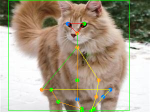

In [ ]:
from mmpose.apis import (inference_top_down_pose_model, init_pose_model,
                         vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector
local_runtime = False
from xtcocotools.coco import COCO
from mmcv import Config
from mmpose.datasets import DatasetInfo
import cv2

try:
  from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
  local_runtime = True


# initialize pose model
pose_config = 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/res50_cats_128x128.py'
pose_checkpoint = 'work_dirs/res50_cats_128x128/latest.pth'
# initialize pose model
pose_model = init_pose_model(pose_config, pose_checkpoint)

# Use coco api to read the validation set 
coco = COCO('data/cats/annotations/val.json')
img_keys = list(coco.imgs.keys())
image_id =  img_keys[-1]
image = coco.loadImgs(image_id)[0]
image_name = os.path.join('data/cats/images', image['file_name'])
ann_ids = coco.getAnnIds(image_id)

config = Config.fromfile(
    './configs/_base_/datasets/cats.py'
)
dataset = pose_model.cfg.data['test']['type']
dataset_info = pose_model.cfg.data['test'].get('dataset_info', None)
if dataset_info is None:
    warnings.warn(
        'Please set `dataset_info` in the config.'
        'Check https://github.com/open-mmlab/mmpose/pull/663 for details.',
        DeprecationWarning)
else:
    dataset_info = DatasetInfo(dataset_info)


# make bounding boxes
box_results = []
for ann_id in ann_ids:
    item = {}
    ann = coco.anns[ann_id]
    # bbox format is 'xywh'
    item['bbox'] = ann['bbox']
    box_results.append(item)

# test a single image, with a list of bboxes
pose_results, returned_outputs = inference_top_down_pose_model(
    pose_model,
    image_name,
    box_results,
    bbox_thr=None,
    format='xywh',
    dataset='AnimalCatsDataset',
    dataset_info=dataset_info)


# show pose estimation results
vis_result = vis_pose_result(pose_model,
                             image_name,
                             pose_results,
                             kpt_score_thr=0.,
                             dataset='AnimalCatsDataset',
                             show=False)

# reduce image size
vis_result = cv2.resize(vis_result, dsize=None, fx=0.5, fy=0.5)

if local_runtime:
  from IPython.display import Image, display
  import tempfile
  import os.path as osp
  import cv2
  with tempfile.TemporaryDirectory() as tmpdir:
    file_name = osp.join(tmpdir, 'pose_results.png')
    cv2.imwrite(file_name, vis_result)
    display(Image(file_name))
else:
  cv2_imshow(vis_result)

### Test

In [ ]:
from mmpose.datasets import build_dataset, build_dataloader
from mmpose.models import build_posenet
from mmpose.apis import single_gpu_test
from mmcv.parallel import MMDataParallel
from mmcv.runner import load_checkpoint
import os
import mmcv

# build dataset
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
test_loader_cfg = {**dict(shuffle=False, drop_last=False), 
              **dict(workers_per_gpu=cfg.data.get('workers_per_gpu', 1)),
              **dict(samples_per_gpu=cfg.data.get('samples_per_gpu', 1)),
              **cfg.data.get('test_dataloader', {})
             }
data_loader = build_dataloader(dataset, **test_loader_cfg)

# build model
model = build_posenet(cfg.model)
model = MMDataParallel(model, device_ids=[0])
load_checkpoint(model, os.path.join(cfg.work_dir, "latest.pth"), map_location='cpu')

# create work_dir
mmcv.mkdir_or_exist(cfg.work_dir)

# train model
outputs = single_gpu_test(model, data_loader)
dataset.evaluate(outputs, cfg.work_dir)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
=> num_images: 200
=> load 223 samples
load checkpoint from torchvision path: torchvision://resnet50


The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias



load checkpoint from local path: work_dirs/res50_cats_128x128/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 110.4 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDet

OrderedDict([('AP', 0.0),
             ('AP .5', 0.0),
             ('AP .75', 0.0),
             ('AP (M)', 0.0),
             ('AP (L)', 0.0),
             ('AR', 0.0),
             ('AR .5', 0.0),
             ('AR .75', 0.0),
             ('AR (M)', 0.0),
             ('AR (L)', 0.0)])

Please simply ignore the evaluation results (0.000). It means nothing. Since the provided "test_info.json" does not contain any ground-truth keypoint annotations, so you cannot evaluate it locally. But you can obtain the "result_keypoints.json" under the work_dir.

### For submission

Finally, you should submit the training config file, model checkpoint, the training logs. They can be found in the work_dir.
TA will running model inference on the test set, and use the mAP of the test set for final performance ranking.

In the following, I will show how to prepare the files for submission.

In [ ]:
%cd ..
# change "123456" to your student ID
%mkdir 123456
%cd 123456
%mkdir models
%cp ../mmpose/work_dirs/res50_cats_128x128/latest.pth ./models/model.pth # model checkpoint (choose the model you like.)
%cp ../mmpose/work_dirs/res50_cats_128x128/None.log.json ./models/ # training log
%cp ../mmpose/configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/res50_cats_128x128.py ./models/ # config file 
%cp ../mmpose/work_dirs/res50_cats_128x128/result_keypoints.json ./
# You also need to prepare the final report.pdf


# You also need to upload the codes and a simple README.txt describing which files are changed.
# NOTICE! Do NOT upload the dataset and the work_dirs. They are too large.

/userhome/35/sjin/WORK
/userhome/35/sjin/WORK/123456
